In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from tqdm import trange

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
train = torchvision.datasets.KMNIST(
                                   root = '../input/',
                                   train =True, 
                                   transform = None,
                                   download = True,
                                   target_transform =None
                                   )
test = torchvision.datasets.KMNIST(
                                   root = '../input/',
                                   train =False, 
                                   transform = None,
                                   download = True,
                                   target_transform =None
                                   )

train.data.shape, train.targets.shape, test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]), torch.Size([10000, 28, 28]))

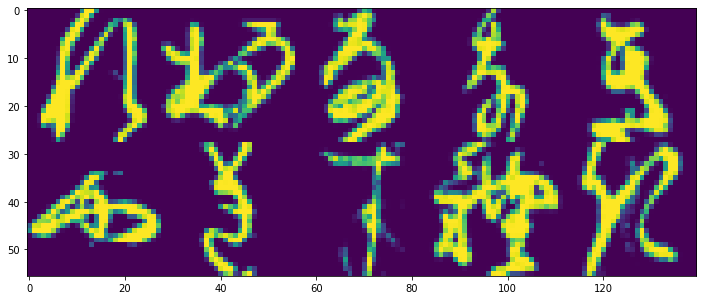

In [3]:
x = train.data
y = train.targets
#------------
x_test = test.data
y_test = test.targets

data = x[:10]#.reshape((4, 3*28, 28))
data = np.vstack(data)
figsize(12, 12)
imshow(np.concatenate(data.reshape((5, 28*2, 28)), axis = 1))

## Torch

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # torch.nn.Linear(in_features: int, out_features: int, bias: bool = True)
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

Loss:  0.796, Accuracy: 0.773: 100%|██████████| 500/500 [00:01<00:00, 374.91it/s]


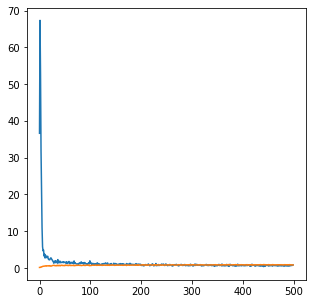

In [5]:
model = Net()
batch = 128
losses, accuracies = [], []
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)
bar = trange(500)
for i in bar:
    samp = np.random.randint(0, x.shape[0], size = batch)
    X = x[samp].reshape(-1, 28*28).float()
    Y = y[samp].long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_func(out, Y)
    loss.backward()
    optim.step()
    loss, acc =  loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(acc)
    bar.set_description('Loss:  %.3f, Accuracy: %.3f' % (loss, acc))

figsize(5, 5)
plot(losses)
plot(accuracies)

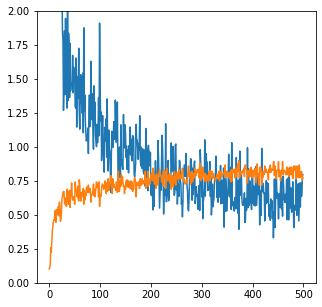

In [6]:
ylim(0, 2)
plot(losses)
plot(accuracies)

In [7]:
y_= model(x_test.reshape(-1, 28*28).float())
pred =  torch.argmax(y_, dim =1)
(y_test == pred).float().mean()

tensor(0.6859)

## NN tensor

In [8]:
from nntensor.tensor import Tensor
import nntensor.optim as optim
import nntensor.utils as utils

In [9]:
# conver to numpy
x = x.numpy()
y = y.numpy()
x_test = x_test.numpy()
y_test = y_test.numpy()

Loss:  0.049, Accuracy: 0.867: 100%|██████████| 500/500 [00:03<00:00, 140.65it/s]


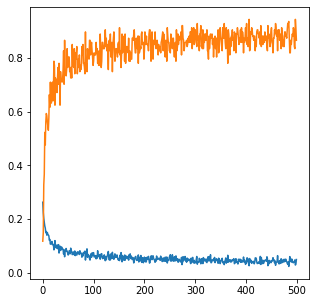

In [10]:
class NN:
    def __init__(self, l1, l2):
        self.l1 = Tensor(l1)
        self.l2 = Tensor(l2)

    def forward(self, x):
        x = x.dot(self.l1)
        x = x.relu()
        x = x.dot(self.l2)
        return x.log_softmax()

# init weight
def weight_init(w: int, h: int , mode = 'gauss') -> np.array:
    """
    w : columns, Width.
    h : rows, Height.
    mode : ['gaussian', 'uniform'] 
    https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073   
    """
    if mode == 'gauss':
        w = np.random.randn(w, h) / np.sqrt(w*h)
    else:
        w = np.random.uniform(-1, 1, size = (w, h)) / np.sqrt(w*h)
    return w.astype(np.float32)


np.random.seed(13)
lr = 0.001
batch = 128
l1 = weight_init(784, 128, mode = 'uniform')
l2 = weight_init(128, 10, mode = 'uniform')

model = NN(l1, l2)
optimizer = optim.SGD([model.l1, model.l2], momentum=0.7)  
# optim = Adam([model.l1, model.l2])  

bar = trange(500)
accuracies, losses = [], []
for i in bar:
    samp = np.random.randint(0, x.shape[0], size=(batch))
    X = Tensor(x[samp].reshape((-1, 28*28)))
    Y = y[samp]
    z = np.zeros((len(samp), 10))
    z[range(z.shape[0]), Y] = 1
    z = Tensor(z)

    y_ = model.forward(X)
    # mean
    # x_loss = (-out * x_lsm).mean(axis=1)
    p1 = y_.mul(z)
    loss = p1.sum().mul(Tensor(np.array([-1/y_.data.size]))) # add minus

    loss.backward()
    optimizer.step()

    cat = np.argmax(y_.data, axis=1)
    acc = (cat == Y).mean()  

    # printing
    loss = loss.data
    losses.append(loss)
    accuracies.append(acc)
    bar.set_description('Loss:  %.3f, Accuracy: %.3f' % (loss, acc)) 
figsize(5, 5)
plot(losses)
plot(accuracies)

Accuracy model:  0.7705
Bad count:  2295

Predicted:  [9 0 1 4 2 0 3 2 6 7 8 4] Target [4 3 2 1 6 9 8 5 4 0 4 9]


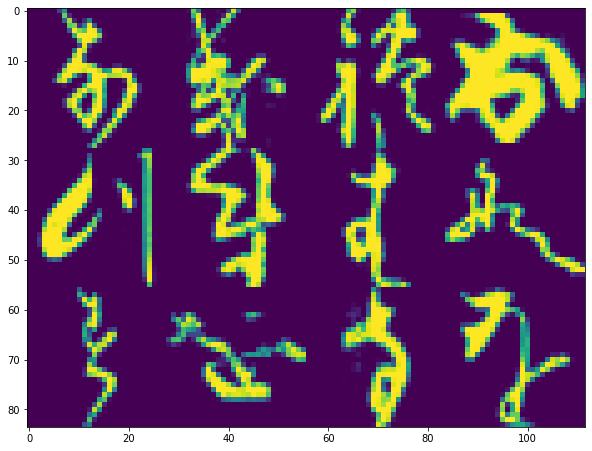

In [11]:
x_test_t = Tensor(x_test.reshape(-1, 28*28))
y_test_t = Tensor(y_test)
pred = utils.evaluate(model, x_test_t, y_test_t)
utils.vis_same_error(x_test, y_test_t, pred)